In [1]:
import tensorflow.compat.v1 as tf1
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.05
session = tf1.Session(config=config)

2024-09-11 18:29:40.214135: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-11 18:29:40.525096: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-11 18:29:42.712141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-11 18:29:45.393258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2016 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capabi

## 데이터 나누기

In [2]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # 원본 데이터 폴더와 목적지 폴더 경로를 정의합니다.
# source_dir = './data'  
# train_dir = './data/Train'
# test_dir = './data/Test'

# # Train과 Test 폴더를 생성합니다. 이미 존재한다면 생성하지 않습니다.
# for folder in ['Train', 'Test']:
#     for sub_folder in ['normal', 'mild']:
#         os.makedirs(os.path.join(source_dir, folder, sub_folder), exist_ok=True)

# # 데이터를 분할하고 파일을 이동하는 함수입니다.
# def split_data(source_folder, train_folder, test_folder, test_size=0.2):
#     # 소스 폴더에서 파일 목록을 가져옵니다.
#     files = os.listdir(source_folder)
    
#     # 파일을 학습 데이터와 테스트 데이터로 분할합니다.
#     train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)
    
#     # 학습 데이터를 Train 폴더로 이동합니다.
#     for file in train_files:
#         shutil.move(os.path.join(source_folder, file), os.path.join(train_folder, file))
    
#     # 테스트 데이터를 Test 폴더로 이동합니다.
#     for file in test_files:
#         shutil.move(os.path.join(source_folder, file), os.path.join(test_folder, file))

# # 'normal'과 'mild' 폴더에 대해 위의 함수를 각각 호출하여 데이터를 분할합니다.
# split_data(os.path.join(source_dir, 'normal'), os.path.join(train_dir, 'normal'), os.path.join(test_dir, 'normal'))
# split_data(os.path.join(source_dir, 'mild'), os.path.join(train_dir, 'mild'), os.path.join(test_dir, 'mild'))

# # 원본 'normal'과 'mild' 폴더가 비었기 때문에 삭제할 수 있습니다.
# os.rmdir(os.path.join(source_dir, 'normal'))
# os.rmdir(os.path.join(source_dir, 'mild'))

# print("학습 데이터와 테스트 데이터 분할이 성공적으로 완료되었습니다.")

---

In [2]:
all_folders = {
    "Train Normal": "data/Train/normal",
    "Train Mild": "data/Train/mild",
    "Test Normal": "data/Test/normal",
    "Test Mild": "data/Test/mild"
}

train_folders = {
    "Train Normal": "data/Train/normal",
    "Train Mild": "data/Train/mild"
}

In [3]:
import glob

def file_count(label, folder_path) :
    count = len(glob.glob(folder_path + '/*'))
    print(f"image in {label} : {count}")
    
for label, folder_path in all_folders.items():
    file_count(label, folder_path)

image in Train Normal : 2560
image in Train Mild : 716
image in Test Normal : 640
image in Test Mild : 180


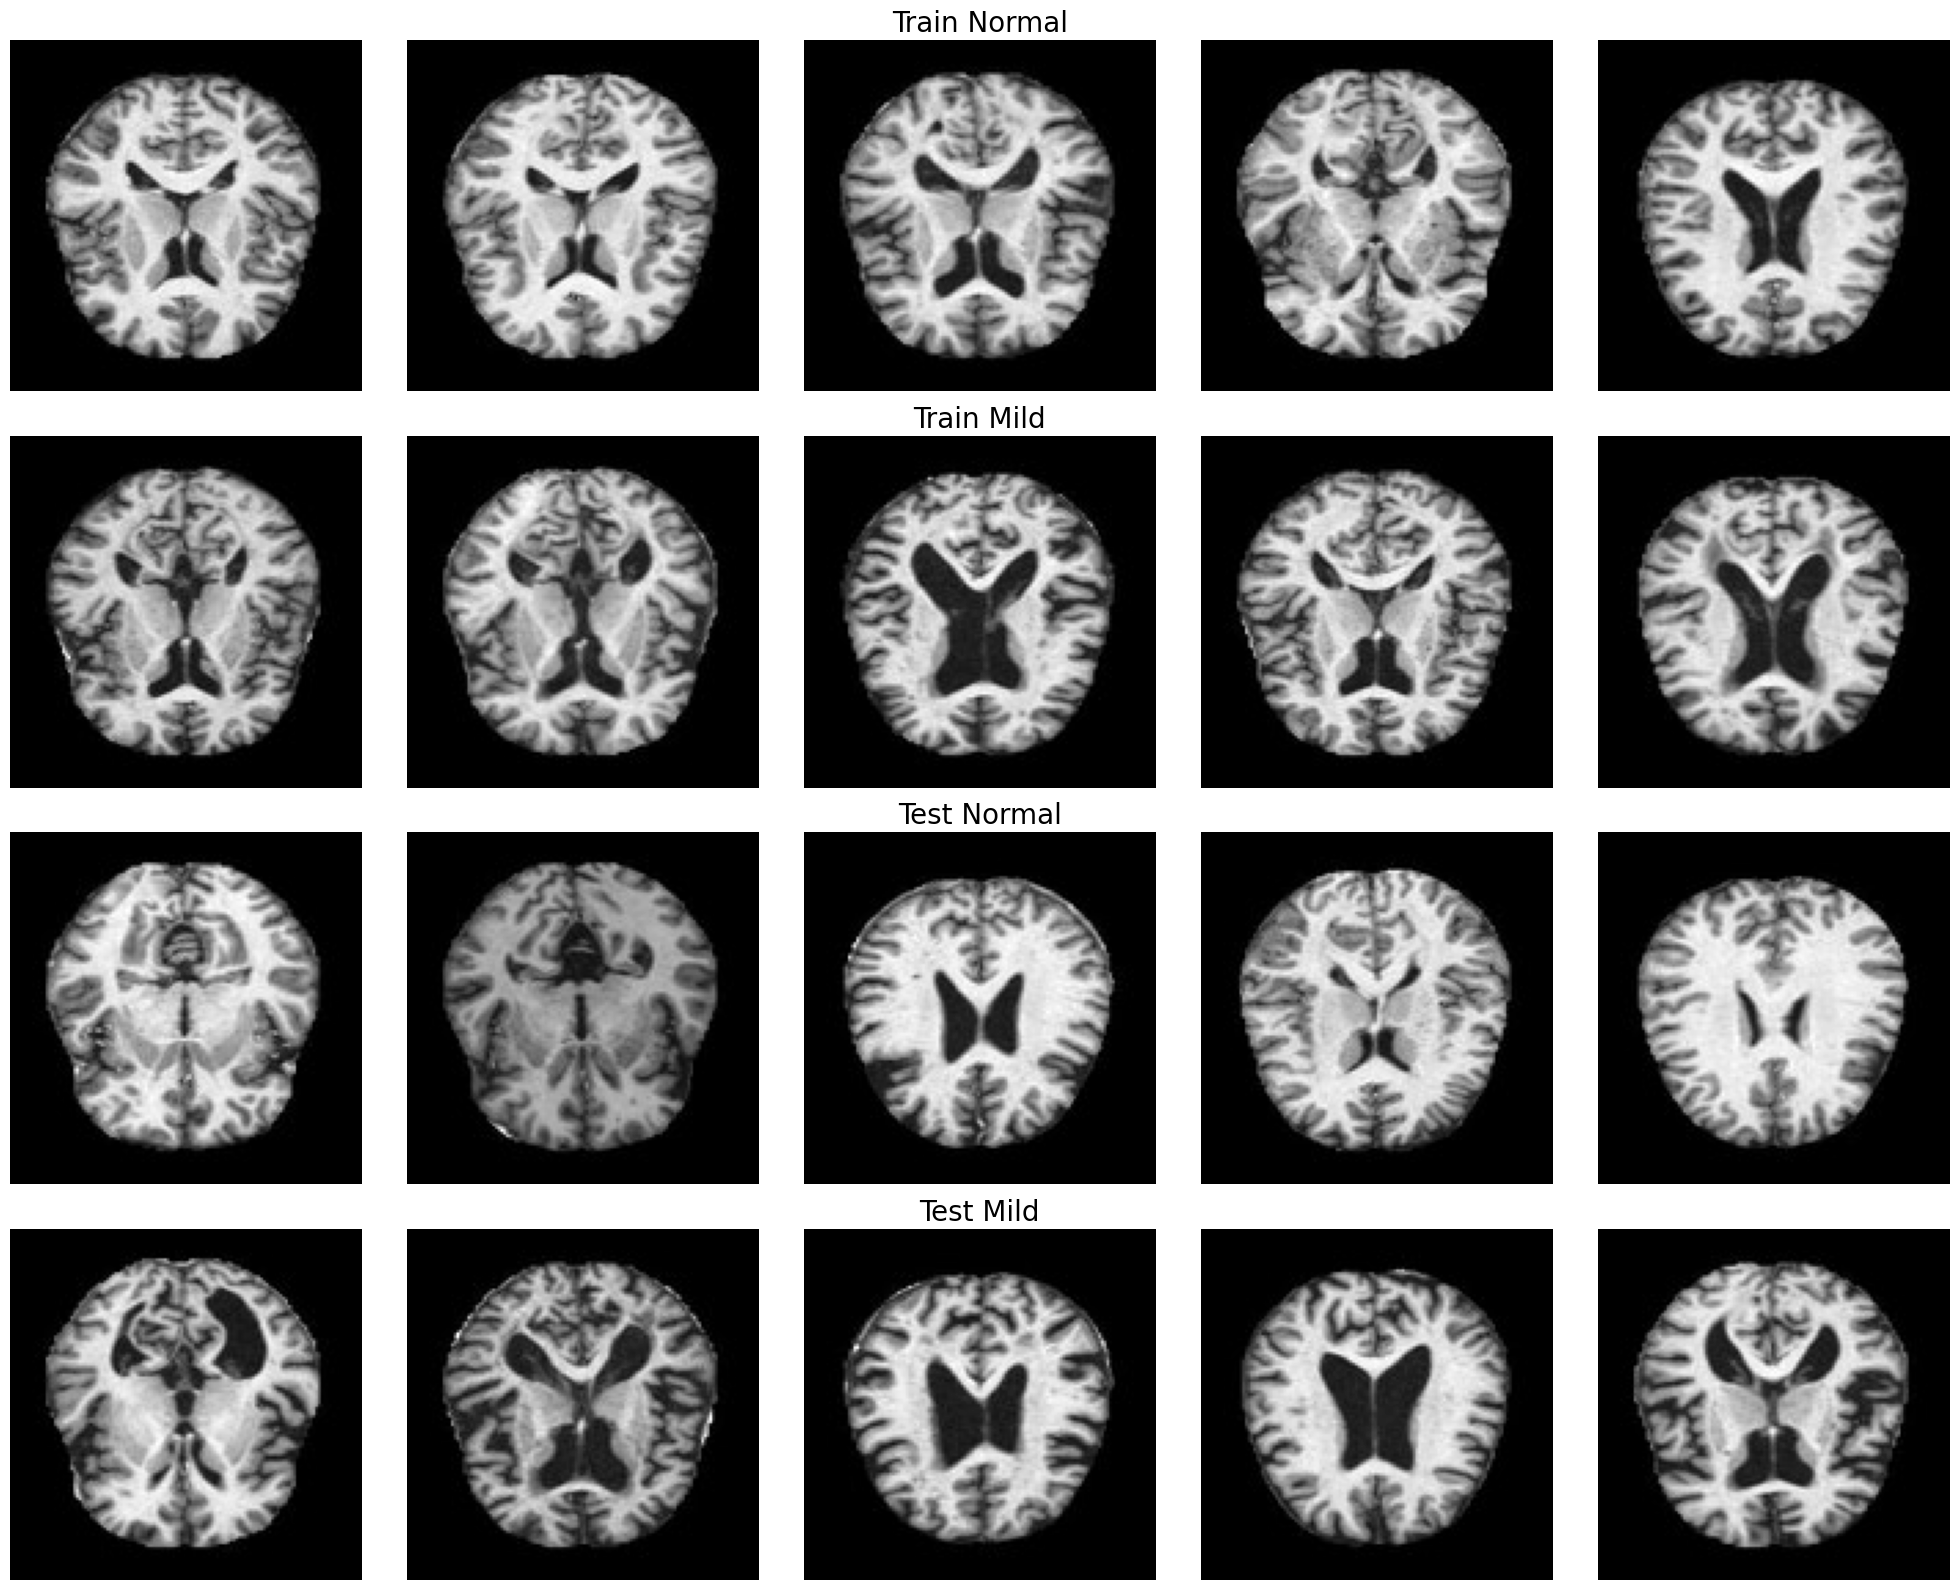

In [4]:
import matplotlib.pyplot as plt
import os
import random

fig, axs = plt.subplots(4, 5, figsize=(20, 16)) # 5열 4행의 플롯 생성

for i, (label, folder_path) in enumerate(all_folders.items()):
    images = os.listdir(folder_path) # 폴더 내의 모든 이미지 파일 리스트
    if len(images) < 5: # 이미지가 5개 미만인 경우 모든 이미지 사용
        selected_images = images
    else:
        selected_images = random.sample(images, 5) # 랜덤으로 5개의 이미지 선택

    for j, img in enumerate(selected_images):
        img_path = os.path.join(folder_path, img) # 이미지의 전체 경로
        image = plt.imread(img_path) # 이미지 읽기
        axs[i, j].imshow(image, cmap='gray') # 이미지 표시, 흑백으로 설정
        axs[i, j].axis('off') # 축 숨기기
    axs[i, 2].set_title(label, fontsize=20) # 각 행의 첫 번째 열에 레이블 표시

plt.tight_layout()
plt.show()

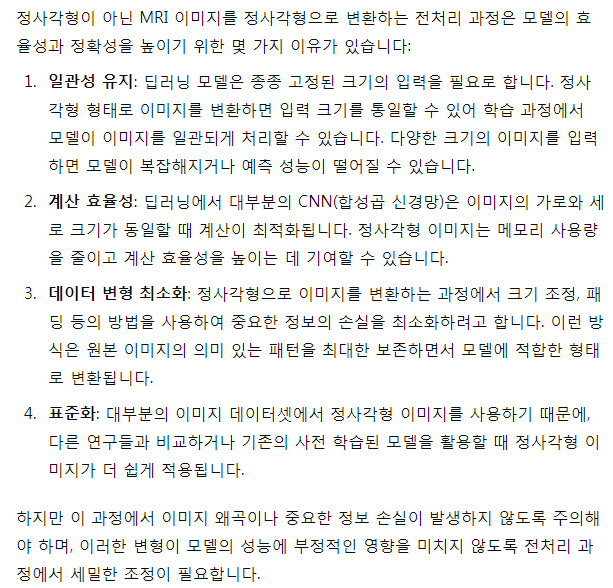

---

## 밝기 히스토그램 기반

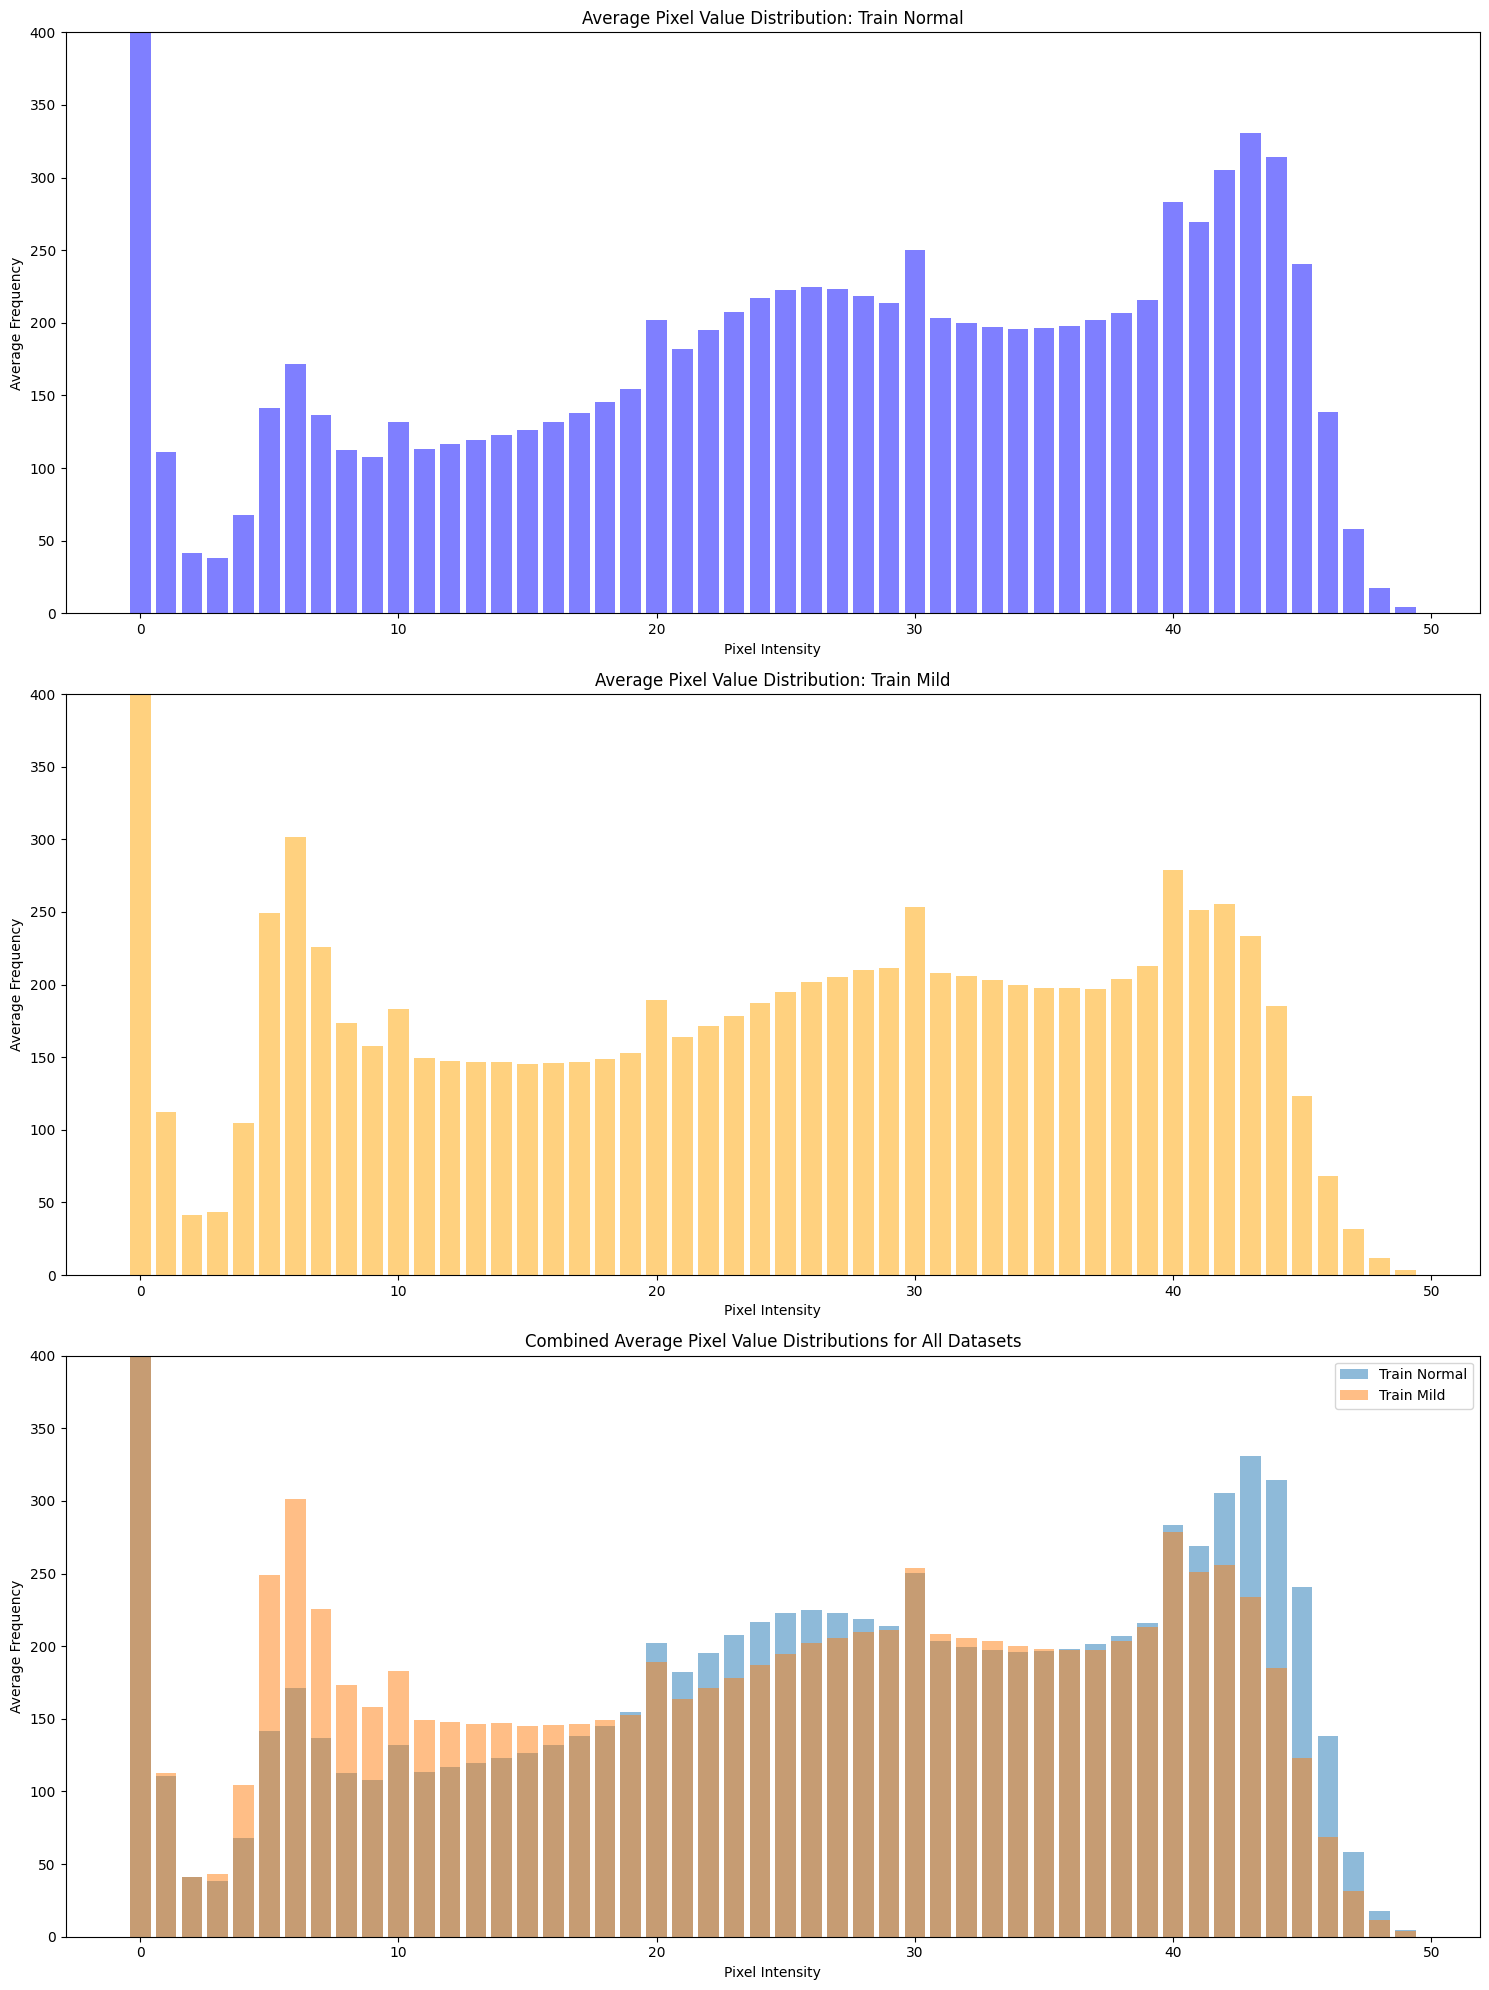

In [5]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

train_folders = {
    "Train Normal": "data/Train/normal",
    "Train Mild": "data/Train/mild",
}


def load_all_images_pixel_values(path):
    """
    Load pixel values for all images in the specified path and calculate the average histogram.
    """
    files = os.listdir(path)
    histograms = []

    for file in files:
        image = Image.open(os.path.join(path, file))
        pixel_values = np.array(image).flatten()  # Convert image to a 1D array of pixel values
        hist, _ = np.histogram(pixel_values, bins=50, range=(0, 255))
        histograms.append(hist)

    # Calculate the average histogram
    avg_histogram = np.mean(histograms, axis=0)
    return avg_histogram

# Load average pixel values histogram for all images in each dataset
avg_pixel_values_histograms = {name: load_all_images_pixel_values(path) for name, path in train_folders.items()}

# Plotting the average histograms
plt.figure(figsize=(15, 20))
colors = ['blue', 'orange']

for i, (name, avg_histogram) in enumerate(avg_pixel_values_histograms.items(), 1):
    plt.subplot(3, 1, i)
    plt.bar(range(50), avg_histogram, color=colors[i-1], alpha=0.5)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Average Frequency')
    plt.title(f'Average Pixel Value Distribution: {name}')
    plt.ylim(0, 400) 
# Combined histogram
plt.subplot(3, 1, 3)
for name, avg_histogram in avg_pixel_values_histograms.items():
    plt.bar(range(50), avg_histogram, alpha=0.5, label=name)
    plt.ylim(0, 400) 
    
plt.xlabel('Pixel Intensity')
plt.ylabel('Average Frequency')
plt.title('Combined Average Pixel Value Distributions for All Datasets')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
avg_pixel_values_histograms

{'Train Normal': array([8.01995625e+03, 1.10892578e+02, 4.14390625e+01, 3.83390625e+01,
        6.78484375e+01, 1.41359766e+02, 1.71533594e+02, 1.36507812e+02,
        1.12372656e+02, 1.07972266e+02, 1.31916406e+02, 1.13457031e+02,
        1.16528516e+02, 1.19468359e+02, 1.22838672e+02, 1.26242578e+02,
        1.31664453e+02, 1.37901172e+02, 1.45303516e+02, 1.54782031e+02,
        2.01864453e+02, 1.82280078e+02, 1.95391406e+02, 2.07677734e+02,
        2.16918750e+02, 2.22921094e+02, 2.24628516e+02, 2.23153125e+02,
        2.18437891e+02, 2.13856641e+02, 2.50260938e+02, 2.03561328e+02,
        1.99785937e+02, 1.97490625e+02, 1.95907813e+02, 1.96711719e+02,
        1.97806641e+02, 2.01754297e+02, 2.06696484e+02, 2.15919531e+02,
        2.83521875e+02, 2.69244922e+02, 3.05564844e+02, 3.30680469e+02,
        3.14408594e+02, 2.40528906e+02, 1.38326562e+02, 5.83019531e+01,
        1.77269531e+01, 4.34570312e+00]),
 'Train Mild': array([8.02574441e+03, 1.12476257e+02, 4.14511173e+01, 4.321368

---

## GLCM 특징 기반

In [20]:
from skimage.feature import graycoprops, graycomatrix
from skimage import io, color
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tqdm import tqdm  # 진행도 바를 위한 tqdm 라이브러리

def get_avg_glcm_features_with_progress(path):
    """
    Calculate the average GLCM features for all images in the specified path with a progress bar.
    """
    files = os.listdir(path)
    feature_sums = None

    for file in tqdm(files, desc=f"Processing {os.path.basename(path)}"):
        image_path = os.path.join(path, file)
        image = Image.open(image_path)
        gray_image = np.array(image.convert('L'))

        # GLCM 계산
        glcm = graycomatrix(gray_image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], 256, symmetric=True, normed=True)

        # 현재 이미지의 GLCM 특징
        features = {
            'contrast': graycoprops(glcm, 'contrast')[0, 0],
            'dissimilarity': graycoprops(glcm, 'dissimilarity')[0, 0],
            'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
            'energy': graycoprops(glcm, 'energy')[0, 0],
            'correlation': graycoprops(glcm, 'correlation')[0, 0]
        }

        # 모든 특징들의 합계 계산
        if feature_sums is None:
            feature_sums = features
        else:
            for key in features:
                feature_sums[key] += features[key]

    # 평균 특징 계산
    num_images = len(files)
    avg_features = {key: value / num_images for key, value in feature_sums.items()}
    return avg_features

def plot_glcm_features(features, title):
    """
    Visualize the GLCM features as a bar chart.
    """
    keys = list(features.keys())
    values = list(features.values())

    plt.figure(figsize=(10, 6))
    plt.bar(keys, values, color='skyblue')
    plt.title(f'Average GLCM Features for {title}')
    plt.ylabel('Value')
    plt.xlabel('GLCM Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [21]:
# 각 데이터셋의 모든 이미지에 대한 평균 GLCM 특징을 계산
avg_glcm_features_datasets = {name: get_avg_glcm_features_with_progress(path) for name, path in train_folders.items()}

Processing mild: 100%|██████████| 716/716 [01:02<00:00, 11.40it/s]


In [27]:
# 평균 GLCM 특징 출력
for name, features in avg_glcm_features_datasets.items():
    print(f"🔍 {name}")
    for feature, value in features.items():
        print(f"'{feature}': {value}")
    print()

🔍 Train Normal
'contrast': 312.13759361931085
'dissimilarity': 9.255150454063687
'homogeneity': 0.4743472724943206
'energy': 0.4083064375647692
'correlation': 0.9779184235483094

🔍 Train Mild
'contrast': 337.63149180160104
'dissimilarity': 9.729819913507542
'homogeneity': 0.47251779715635234
'energy': 0.4088230212121632
'correlation': 0.9733744864722645



> Contrast(대비)와 Dissimilarity(불일치)가 경증 치매 환자에서 더 높게 나타나는 것은 뇌 백질과 회백질 간 경계의 명료도 감소 또는 뇌의 구조적 퇴화를 시사합니다. 치매 환자의 뇌에서는 신경 세포 손실 및 조직 퇴화로 인해 텍스처가 불규칙해지고, 이러한 변화는 이미지 내 픽셀 값 사이의 차이를 증가시키는 방향으로 나타납니다.
> 
> * 대비(Contrast) : 이미지에서 인접한 픽셀 사이의 밝기 차이를 나타냅니다. 대비 값이 높을수록 이미지에서 밝은 부분과 어두운 부분 간의 차이가 커서 경계가 명확하다는 의미입니다. 반대로, 대비 값이 낮으면 픽셀 간의 밝기 차이가 적고, 경계가 덜 명확하다는 것을 의미합니다.
> 
> * 불일치(Dissimilarity) : 대비와 유사하지만, 픽셀 간의 차이를 덜 강조하여 비교적 부드러운 차이를 반영하는 척도입니다. 불일치 값이 높으면 이미지의 픽셀 간 밝기 차이가 크다는 뜻이며, 불일치 값이 낮으면 픽셀 간의 차이가 적고 더 균일하다는 의미입니다.
> 
> <hr>
> Homogeneity(동질성) 값이 정상인과 치매 환자에서 큰 차이는 없지만, 치매 환자의 경우 약간 낮은 값을 보입니다. 이는 뇌의 텍스처가 치매로 인해 더 복잡해지고, 고유한 구조적 패턴이 상실되면서 뇌 조직의 균일성이 감소하는 것을 암시할 수 있습니다.
> 
> * 동질성(Homogeneity) : 이미지 내 인접한 픽셀들이 얼마나 유사한지를 나타냅니다. 동질성 값이 높으면 이미지가 더 균일하고, 비슷한 밝기를 가진 픽셀들이 많다는 의미입니다. 반대로 동질성 값이 낮으면, 이미지에서 픽셀 간 밝기 차이가 커서 더 복잡하고 불규칙한 텍스처를 가진다는 뜻입니다.
> 
> <hr>
> Correlation(상관성)이 정상인에 비해 치매 환자에서 약간 감소한 것은, 뇌의 특정 영역들이 더 불규칙해지고 백질과 회백질의 경계가 흐려지는 현상을 나타냅니다. 이는 치매의 진행 과정에서 뇌 구조가 무너지고 신경 섬유의 연결성이 감소하며, 결국 뇌 기능의 손상으로 이어지는 과정을 반영할 수 있습니다.
> 
> * 상관성(Correlation) : 이미지에서 인접한 픽셀들 간의 상관 관계를 나타냅니다. 상관성 값이 높으면, 픽셀 간 밝기 변화가 일정한 패턴을 따라가는 경향이 있다는 의미입니다. 상관성 값이 낮으면, 픽셀 간의 밝기 변화가 무작위적으로 나타나며 예측하기 어려운 불규칙한 패턴을 가진다는 것을 의미합니다.

---

## 웨이블렛 변환

Train_Normal_Wavelet_Transform.txt에 저장되었습니다.
Train_Mild_Wavelet_Transform.txt에 저장되었습니다.
Train_Normal_vs_Train_Mild_Wavelet_Difference.txt에 저장되었습니다.


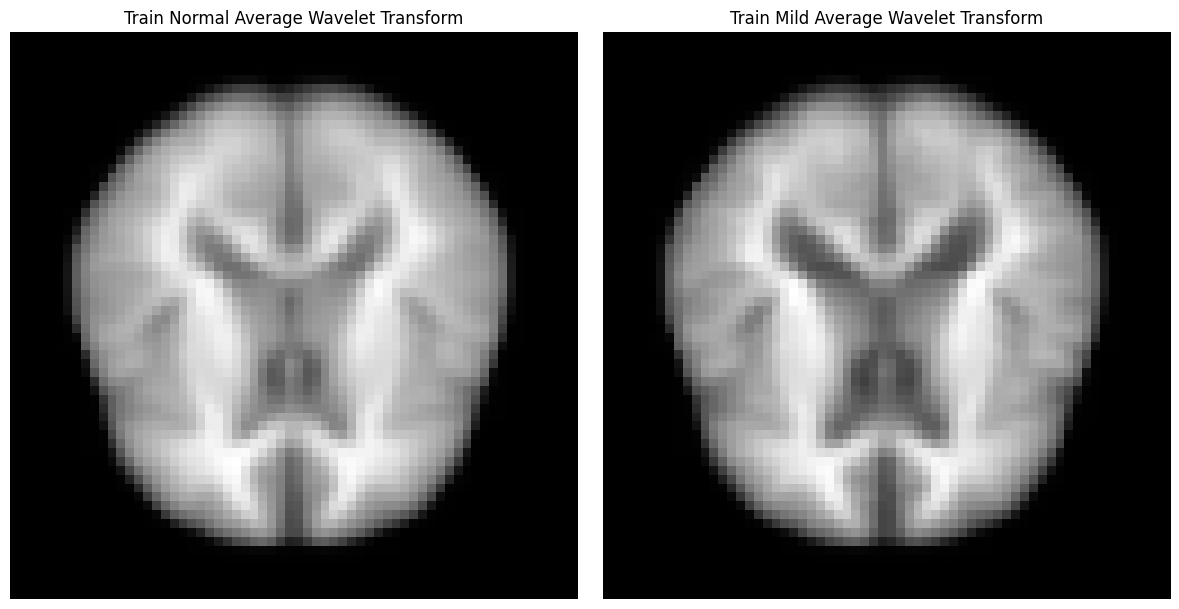

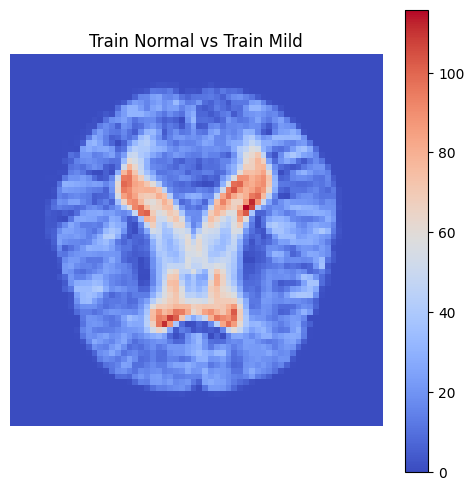

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pywt
from PIL import Image

# train_folders 경로 설정
train_folders = {
    "Train Normal": "data/Train/normal",
    "Train Mild": "data/Train/mild",
}

def calculate_average_wavelet_transform(path, wavelet='haar'):
    """
    지정된 경로의 모든 이미지에 대해 웨이블렛 변환을 적용한 후, 평균 웨이블렛 계수를 계산하는 함수.
    """
    files = os.listdir(path)
    coeffs_list = []

    for file in files:
        # 이미지 열기 및 그레이스케일로 변환
        image = Image.open(os.path.join(path, file)).convert('L')
        image_np = np.array(image)

        # 2D 웨이블렛 변환 적용
        coeffs2 = pywt.dwt2(image_np, wavelet)  # 2D 웨이블렛 변환
        cA, (cH, cV, cD) = coeffs2  # 저주파 성분과 고주파 성분 추출

        # 저주파 성분(cA)을 저장 (이미지의 전체 구조 정보를 담음)
        coeffs_list.append(cA)

    # 모든 이미지의 저주파 성분에 대한 평균 계산
    avg_coeffs = np.mean(coeffs_list, axis=0)
    
    return avg_coeffs

def save_to_file(filename, data):
    """
    수치 데이터를 텍스트 파일로 저장하는 함수.
    """
    np.savetxt(filename, data, fmt='%.5f', delimiter=',')
    print(f"{filename}에 저장되었습니다.")

# 각 데이터셋의 모든 이미지에 대한 평균 웨이블렛 변환 계산
avg_wavelet_transforms = {name: calculate_average_wavelet_transform(path) for name, path in train_folders.items()}

# 결과를 텍스트 파일로 저장
save_to_file('Train_Normal_Wavelet_Transform.txt', avg_wavelet_transforms["Train Normal"])
save_to_file('Train_Mild_Wavelet_Transform.txt', avg_wavelet_transforms["Train Mild"])

# Train Normal과 Train Mild의 웨이블렛 변환 차이 계산
difference_wavelet = np.abs(avg_wavelet_transforms["Train Normal"] - avg_wavelet_transforms["Train Mild"])

# 차이 값을 파일로 저장
save_to_file('Train_Normal_vs_Train_Mild_Wavelet_Difference.txt', difference_wavelet)

# 시각화
plt.figure(figsize=(12, 6))

# Train Normal (정상인) 평균 웨이블렛 변환 시각화
plt.subplot(1, 2, 1)
plt.imshow(avg_wavelet_transforms["Train Normal"], cmap='gray')
plt.title('Train Normal Average Wavelet Transform')
plt.axis('off')

# Train Mild (경증 치매 환자) 평균 웨이블렛 변환 시각화
plt.subplot(1, 2, 2)
plt.imshow(avg_wavelet_transforms["Train Mild"], cmap='gray')
plt.title('Train Mild Average Wavelet Transform')
plt.axis('off')

plt.tight_layout()
plt.show()

# 두 군집의 웨이블렛 변환 차이 시각화
plt.figure(figsize=(6, 6))
plt.imshow(difference_wavelet, cmap='coolwarm')
plt.title('Train Normal vs Train Mild')
plt.colorbar()
plt.axis('off')
plt.show()

### 시각화 설명

> Train Normal Average Wavelet Transform (정상인 평균 웨이블렛 변환)
> 
> 이 이미지에서는 정상인의 MRI 이미지에서 저주파 성분을 강조한 웨이블렛 변환 결과를 보여줍니다. 저주파 성분은 이미지의 전반적인 구조나 큰 형태를 나타내는 부분입니다. 여기서 우리는 뇌의 큰 윤곽이나 백질과 회백질의 구분을 확인할 수 있습니다.

> Train Mild Average Wavelet Transform (경증 치매 환자 평균 웨이블렛 변환)
> 
> 이 이미지에서는 경증 치매 환자의 MRI 이미지에서 저주파 성분을 강조한 웨이블렛 변환 결과를 보여줍니다. 경증 치매 환자의 경우, 뇌의 구조가 일부 변형되거나 퇴화된 부분이 있을 수 있습니다. 이로 인해 정상인과 비교했을 때 뇌의 전체적인 구조나 패턴에서 차이가 보일 수 있습니다.

> Train Normal vs Train Mild (정상인 vs 경증 치매 환자)
> 
> 이 시각화는 정상인과 경증 치매 환자의 웨이블렛 변환 결과 간의 차이를 나타냅니다. 두 이미지의 차이(절대값)를 계산하여, 뇌 구조에서 두 그룹 간의 변화를 시각적으로 확인할 수 있습니다. 
> 
> 백질이 감소하면 MRI 이미지에서 뇌의 가운데 부분에 있는 뇌실(Ventricles)이 더 커지고 넓어질 수 있습니다.
> 
> 백질이 주로 신경 섬유로 구성되어 있는데, 치매나 나이와 관련된 뇌 위축이 진행되면 백질이 감소하면서 뇌실 확장(Ventricular enlargement)이 나타납니다. 뇌실은 뇌척수액이 흐르는 공간으로, 백질이 줄어들면 이 공간이 더 넓어져 보이게 됩니다. 특히 알츠하이머와 같은 치매에서는 뇌실 확장이 두드러지며, 이는 뇌 조직의 퇴화와 위축을 나타내는 중요한 지표입니다.
> 
> 따라서 뇌 백질의 감소는 MRI 이미지에서 뇌실이 더 넓어지는 형태로 나타날 가능성이 높습니다.

## 이해를 돕기 위한 설명

> 이미지에서 주파수란 변화의 빈도를 의미합니다. 즉, 이미지의 픽셀 값들이 얼마나 자주, 얼마나 크게 변하는지를 나타냅니다.
> 
> 저주파 성분 (Low frequency components) : 이미지에서 완만한 변화를 나타냅니다. 이미지의 전체적인 구조나 큰 윤곽을 표현합니다. 예를 들어, 부드러운 그라데이션이나 큰 색상 블록 같은 부분이 저주파 성분에 해당합니다.
> 
> 고주파 성분 (High frequency components) : 급격한 변화를 나타냅니다. 즉, 이미지에서 세부적인 부분, 경계선, 텍스처와 같은 요소들이 고주파 성분에 속합니다. 픽셀 값이 빠르게 변하는 영역(예: 윤곽선, 경계, 세밀한 디테일)이 고주파 성분에서 주로 나타납니다.
> 
> 예를 들어, 뇌 MRI 이미지를 분석할 때 :
> 
> 저주파 성분은 뇌의 전체적인 윤곽이나 큰 구조를 강조하며, 뇌실, 피질과 백질 간의 경계를 포괄적으로 보여줄 수 있습니다.
고주파 성분은 세부적인 구조적 변화를 보여주며, 치매 환자에서 나타나는 백질 손상이나 미세한 변화를 감지할 수 있습니다.
따라서 이미지에서 주파수는 픽셀 값 변화의 정도를 표현하며, 이를 통해 이미지의 구조적 특징이나 세부 사항을 분석할 수 있습니다.

In [15]:
import numpy as np

# 'normal'과 'mild' 결과 데이터 로드
normal_data = np.loadtxt('Train_Normal_Wavelet_Transform.txt', delimiter=',')
mild_data = np.loadtxt('Train_Mild_Wavelet_Transform.txt', delimiter=',')

# 두 데이터의 차이 계산
difference_data = np.abs(normal_data - mild_data)

# 두 데이터의 통계적 분석 (평균, 표준편차)
normal_mean = np.mean(normal_data)
mild_mean = np.mean(mild_data)
difference_mean = np.mean(difference_data)

normal_std = np.std(normal_data)
mild_std = np.std(mild_data)
difference_std = np.std(difference_data)

# 결과를 저장하고 출력
results = {
    "Normal Mean": normal_mean,
    "Mild Mean": mild_mean,
    "Difference Mean": difference_mean,
    "Normal Std Dev": normal_std,
    "Mild Std Dev": mild_std,
    "Difference Std Dev": difference_std
}

results

{'Normal Mean': 146.941841809082,
 'Mild Mean': 133.52578479003904,
 'Difference Mean': 13.53248456298828,
 'Normal Std Dev': 153.56543807340321,
 'Mild Std Dev': 141.76423650449652,
 'Difference Std Dev': 20.272437719719868}

Normal Mean (146.94): 정상인의 뇌 이미지에서 큰 구조(저주파 성분)의 평균 값입니다. 이 값이 높다는 것은 정상인의 뇌 구조가 더 밝고 건강해 보인다는 것을 의미합니다.

Mild Mean (133.53): 경증 치매 환자의 뇌 이미지에서 같은 저주파 성분의 평균 값입니다. 정상인보다 낮은 값은 치매 환자의 뇌 구조가 어두워지고 변화가 시작되었다는 것을 시사합니다.

Difference Mean (13.53): 정상인과 경증 치매 환자 간의 평균 차이입니다. 이 차이는 경증 치매 환자의 뇌가 정상인보다 뚜렷한 변화를 겪고 있음을 나타냅니다.

Normal Std Dev (153.57): 정상인의 뇌 이미지에서 나타나는 구조의 변동성을 보여줍니다. 값이 크다는 것은 정상인의 뇌가 다양한 구조적 특징을 가지고 있다는 뜻입니다.

Mild Std Dev (141.76): 경증 치매 환자의 뇌에서는 이 변동성이 좀 더 작습니다, 즉 뇌 구조가 덜 다양하고 변화된 패턴을 보일 수 있다는 의미입니다.

Difference Std Dev (20.27): 정상인과 치매 환자의 변동성 차이를 보여줍니다. 경증 치매 환자의 뇌는 더 일관된 변화를 겪고 있다고 볼 수 있습니다.

---

## 결과 분석

### 1. 밝기 히스토그램 기반 분석 결과 해석
> MRI의 밝기 히스토그램은 뇌 실질의 구조적 특성과 직결됩니다. 밝기 값은 일반적으로 뇌 조직의 밀도나 구성을 반영하며, 치매 환자의 경우 이러한 조직의 변화가 MRI 이미지에 나타날 수 있습니다.
> 
> 백질은 미엘린이라는 지방 성분이 많아 상대적으로 밝게 나타나며, 회백질은 중간 정도의 밝기를 나타냅니다.
> 
> 정상인은 히스토그램에서 중간 및 높은 밝기 영역에서 더 높은 빈도를 보입니다. 이는 정상인의 뇌 실질, 특히 백질과 회백질의 구조가 치매 환자보다 더 건강하게 유지되고 있음을 나타낼 수 있습니다. 반면, 경증 치매 환자는 중간 및 높은 밝기 영역에서 상대적으로 낮은 빈도를 보이며, 이는 백질 및 회백질의 손상으로 인해 뇌 구조의 변화가 일어났을 가능성을 시사합니다.

<hr>

###  2. GLCM 특징 기반 분석 결과 해석 
> GLCM 특징 분석은 뇌의 조직 간 질감(텍스처)의 변화를 나타냅니다.
> <hr>
> 분석 결과, 경증 치매 환자의 뇌 MRI 사진에서 정상인과 비교하여 신경 세포 손실과 뇌 조직의 퇴화로 인해 텍스처가 불규칙해지고, 뇌의 구조적 패턴이 흐려지는 변화가 나타났습니다. 이러한 변화로 인해 뇌 조직의 경계가 덜 명확해지며, 이미지에서 픽셀 간 밝기 차이가 커지고, 균일성과 상관성이 감소하여 뇌의 연결성이 약화된 것으로 보입니다.
>
> 뇌의 연결성이 약화된다는 것은 뇌가 정보를 처리하고 소통하는 효율이 떨어지며, 각 부위 간의 협력 기능이 감소한 것을 의미합니다.

<hr>

### 3. 웨이블렛 변환 기반 분석 결과 해석
> 웨이블렛 변환은 MRI 이미지에서 저주파 성분(전체적인 구조 정보)과 고주파 성분(세부적인 경계와 잡음)을 분리하는데 사용되며, 이 분석은 뇌 구조 변화와 밀접한 관련이 있습니다. 
> 
> 분석 결과는 경증 치매 환자의 뇌가 구조적으로 변화하고 있으며, 정상인에 비해 더 어두워지고 변동성도 줄어든다는 것을 보여줍니다. 이는 치매로 인한 뇌의 위축과 연결성이 줄어드는 현상을 반영합니다.
>
> 변동성이 줄어든다는 것 : 정상인들은 개인마다 뇌 구조가 조금씩 다를 수 있지만, 치매 환자들은 특정 패턴의 손상이 공통적으로 나타나기 때문에 뇌 손상이 더 일관되게 나타난다는 해석이 가능합니다.

<hr>

### 4. 결론
> 이 분석 결과는 치매 환자의 뇌가 정상인과 비교하여 구조적으로 퇴화하고 있음을 명확하게 보여줍니다. 특히 뇌 실질 손실과 신경 연결의 감소, 그리고 뇌의 전반적인 구조 변화가 MRI 분석에서 두드러지게 나타났습니다. 
>
> 경증 치매 환자의 뇌는 뇌 실질의 손실로 인해 뇌실 확장이 발생하고, 뇌 표면의 구조적 변화가 시작되며, 이러한 변화는 웨이블렛 변환과 GLCM 분석에서 잘 드러납니다. 특히, 저주파 성분에서 나타난 뇌 구조 손실은 뇌 위축의 초기 단계를 시사합니다.
> 
> 또한, GLCM 분석 결과는 뇌 텍스처의 복잡성 증가와 상관성 감소가 치매 진행 과정의 중요한 특징으로 나타나고 있으며, 이는 신경망 손상과 신경 연결 감소를 반영합니다. 이러한 분석은 경증 치매 단계에서도 뇌 구조의 변화가 명확히 드러난다는 것을 보여주며, 조기 진단의 중요성을 강조합니다. 
>
> 뇌 실질 손실과 같은 구조적 변화는 치매의 진행 속도 예측 및 치료 효과 모니터링에 중요한 지표로 활용될 수 있습니다. 웨이블렛 변환 분석을 통해 치매 초기 단계에서 발생하는 미세한 변화를 포착함으로써, 조기 치료 전략을 수립하는 데 유용한 정보를 제공할 수 있습니다.

### 5. 기대 효과
> 이러한 분석 결과는 치매를 예고하는 생물지표(바이오마커)로 활용될 가능성도 높습니다. 웨이블렛 변환을 통해 뇌 실질 손실과 뇌 위축을 정량적으로 평가하고, GLCM 분석을 통해 신경 연결성의 손상을 조기에 감지할 수 있습니다. 이러한 패턴이 치매의 초기 단계에서 일정한 양상을 보인다면, 이를 통해 치매를 예측하고 조기 진단할 수 있는 신뢰성 있는 생물지표로 사용할 수 있을 것입니다.

Voxel-Based Morphometry (VBM) 방법은  3차원 MRI 데이터를 기반으로 각 뇌의 영역에서 회백질과 백질의 밀도 차이를 정량적으로 비교하는 방법이기 때문에, 단면 이미지만으로는 3D 구조를 반영할 수 없어 사용해보지 못했음 